# Set up 

## Check Environment 

In [2]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Update IAM Roles and Policies

In [3]:
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

In [4]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


## Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install descartes
! pip install geopandas
!pip install wordcloud
import geopandas as gpd
from tqdm import tqdm  
from geopandas import GeoDataFrame, points_from_xy
from wordcloud import WordCloud

  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)
  Using cached geopandas-0.10.2-py2.py3-none-any.whl (1.0 MB)
  Using cached pyproj-3.2.1-cp37-cp37m-manylinux2010_x86_64.whl (6.3 MB)
  Using cached Fiona-1.9.2-cp37-cp37m-manylinux2014_x86_64.whl (16.1 MB)
  Using cached shapely-2.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Attempting uninstall: click
    Found existing installation: Click 7.0
    Uninstalling Click-7.0:
      Successfully uninstalled Click-7.0
  Using cached wordcloud-1.8.2.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (435 kB)


In [6]:
s3_public_path = "s3://sagemaker-studio-458903497716-h2kl4ff3dz/data"

In [7]:
%store s3_public_path

Stored 's3_public_path' (str)


In [8]:
s3_private_path = "s3://{}/gunData".format(bucket)
s3_private_path

's3://sagemaker-us-east-1-458903497716/gunData'

In [9]:
%store s3_private_path

Stored 's3_private_path' (str)


In [10]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --include "*" 

copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/sub_est2018_all.csv to s3://sagemaker-us-east-1-458903497716/gunData/sub_est2018_all.csv
copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/gun_violence.csv to s3://sagemaker-us-east-1-458903497716/gunData/gun_violence.csv


# Create Database Schema in Athena

In [11]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = '{}/gunData'.format(bucket)
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket

'sagemaker-us-east-1-458903497716/gunData'

In [12]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [13]:
#assign database name
database_name = "ads508"

In [14]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [15]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [16]:
#create new database 'ads508'
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
create_db = pd.read_sql(statement, conn)
create_db

""


In [17]:
#verify database creation
q = "SHOW DATABASES"
db_show = pd.read_sql(q, conn)
db_show

,database_name
0,ads508
1,default
2,dsoaws
3,sagemaker_featurestore


## Create Athena Table

In [18]:
# Set Athena parameters
database_name = "ads508"
table_name_csv = "gun_violence"
s3_path = "s3://{}".format(bucket)
print(s3_path)

s3://sagemaker-us-east-1-458903497716/gunData


In [19]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         incident_id int,
         date date,
         state string,
         city_or_county string,
         address string,
         n_killed int,
         n_injured int,
         incident_url string,
         source_url string,
         incident_url_fields_missing string,
         congressional_district int,
         gun_stolen string,
         gun_type string,
         incident_characteristics string,
         latitude int,
         location_description string,
         longitude int,
         n_guns_involved int,
         notes string,
         participant_age string,
         participant_age_group string,
         participant_gender string,
         participant_name string,
         participant_relationship string,
         participant_status string,
         participant_type string,
         sources string,
         state_house_district int,
         state_senate_district int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_path
)

create_table = pd.read_sql(statement, conn)
create_table

""


In [20]:
table_name_csv_1 = "est2018"
s3_path_1 = "s3://{}/census2010_data".format(bucket)
print(s3_path_1)

s3://sagemaker-us-east-1-458903497716/gunData/census2010_data


In [21]:
# SQL statement to execute

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    sumlev int,
    state int,
    county int,
    place int,
    cousub int,
    concit int,
    primgeo_flag int,
    funcstat int,
    name string,
    stname string,
    census2010pop int,
    estimatesbase2010 int,
    popestimates2010 int,
    popestimates2011 int,
    popestimates2012 int,
    popestimates2013 int,
    popestimates2014 int,
    popestimates2015 int,
    popestimates2016 int,
    popestimates2017 int,
    popestimates2018 int
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_1, s3_path_1
)

create_table_1 = pd.read_sql(statement, conn)
create_table_1

""


In [22]:
statement = "SHOW TABLES in ads508"
tables = pd.read_sql(statement, conn)
tables

,tab_name
0,est2018
1,gun_violence


In [23]:
statement = "SELECT * from ads508.gun_violence LIMIT 100"
df = pd.read_sql(statement, conn)
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,NaN,None,None,None,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,NaN,NaN
1,NaN,None,None,None,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,NaN,NaN
2,NaN,None,None,None,None,NaN,NaN,None,None,None,...,None,None,None,None,None,None,None,None,NaN,NaN
3,40.0,None,0::38,0::Adult 18+,0::Male||1::Male||2::Male,NaN,NaN,0::Injured||1::Unharmed||2::Unharmed,0::Victim||1::Subject-Suspect||2::Subject-Suspect,http://nypost.com/2016/02/15/daily-blotter-790/,...,None,None,None,None,None,None,None,None,NaN,NaN
4,505961.0,2016-02-12,South Carolina,North Myrtle Beach,,0.0,0.0,http://www.gunviolencearchive.org/incident/505961,http://www.wistv.com/story/31230611/man-chased...,False,...,2::34,0::Teen 12-17||1::Teen 12-17||2::Adult 18+,0::Male||1::Male||2::Male,2::Richard Brandon Suggs,,"""0::Unharmed||1::Unharmed||2::Unharmed","Arrested""",0::Victim||1::Victim||2::Subject-Suspect,NaN,104.0


In [24]:
statement = "SELECT * from ads508.est2018 LIMIT 100"
df_pop = pd.read_sql(statement, conn)
df_pop.head(5)

,sumlev,state,county,place,cousub,concit,primgeo_flag,funcstat,name,stname,...,estimatesbase2010,popestimates2010,popestimates2011,popestimates2012,popestimates2013,popestimates2014,popestimates2015,popestimates2016,popestimates2017,popestimates2018
0,40,1,0,0,0,0,0,None,Alabama,Alabama,...,4780138,4785448,4798834,4815564,4830460,4842481,4853160,4864745,4875120,4887871
1,162,1,0,124,0,0,0,None,Abbeville city,Alabama,...,2688,2684,2677,2629,2612,2595,2588,2573,2566,2563
2,162,1,0,460,0,0,0,None,Adamsville city,Alabama,...,4516,4510,4496,4474,4453,4432,4406,4373,4342,4325
3,162,1,0,484,0,0,0,None,Addison town,Alabama,...,754,751,751,744,743,740,735,734,728,724
4,162,1,0,676,0,0,0,None,Akron town,Alabama,...,356,355,345,345,341,339,337,332,332,330


# Insert Dataset into Pandas Dataframe

In [24]:
df = pd.read_csv("{}/gun_violence.csv".format(s3_path))
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


# Data Overview

In [25]:
print(df.shape)

(239677, 29)


### The dataset contains 239,677 rows and 29 attributes. 

## Show data types

In [26]:
df.dtypes

incident_id                      int64
date                            object
state                           object
city_or_county                  object
address                         object
n_killed                         int64
n_injured                        int64
incident_url                    object
source_url                      object
incident_url_fields_missing       bool
congressional_district         float64
gun_stolen                      object
gun_type                        object
incident_characteristics        object
latitude                       float64
location_description            object
longitude                      float64
n_guns_involved                float64
notes                           object
participant_age                 object
participant_age_group           object
participant_gender              object
participant_name                object
participant_relationship        object
participant_status              object
participant_type         

## Show null counts

In [27]:
df.isnull().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

## Show percentage of null values

In [28]:
100*(df.isnull().sum())/len(df.index)

incident_id                     0.000000
date                            0.000000
state                           0.000000
city_or_county                  0.000000
address                         6.883013
n_killed                        0.000000
n_injured                       0.000000
incident_url                    0.000000
source_url                      0.195263
incident_url_fields_missing     0.000000
congressional_district          4.983373
gun_stolen                     41.513370
gun_type                       41.493760
incident_characteristics        0.136016
latitude                        3.305699
location_description           82.439283
longitude                       3.305699
n_guns_involved                41.493760
notes                          33.802576
participant_age                38.509327
participant_age_group          17.573234
participant_gender             15.171251
participant_name               51.007397
participant_relationship       93.418643
participant_stat

## Describe all numeric variables

In [29]:
df.describe()

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
count,2.396770e+05,239677.000000,239677.000000,227733.000000,231754.000000,231754.000000,140226.000000,200905.000000,207342.00000
mean,5.593343e+05,0.252290,0.494007,8.001265,37.546598,-89.338348,1.372442,55.447132,20.47711
std,2.931287e+05,0.521779,0.729952,8.480835,5.130763,14.359546,4.678202,42.048117,14.20456
min,9.211400e+04,0.000000,0.000000,0.000000,19.111400,-171.429000,1.000000,1.000000,1.00000
25%,3.085450e+05,0.000000,0.000000,2.000000,33.903400,-94.158725,1.000000,21.000000,9.00000
50%,5.435870e+05,0.000000,0.000000,5.000000,38.570600,-86.249600,1.000000,47.000000,19.00000
75%,8.172280e+05,0.000000,1.000000,10.000000,41.437375,-80.048625,1.000000,84.000000,30.00000
max,1.083472e+06,50.000000,53.000000,53.000000,71.336800,97.433100,400.000000,901.000000,94.00000


## Describe all string variables

In [30]:
df.describe(include=[object])

,date,state,city_or_county,address,incident_url,source_url,gun_stolen,gun_type,incident_characteristics,location_description,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources
count,239677,239677,239677,223180,239677,239209,140179,140226,239351,42089,158660,147379,197558,203315,117424,15774,212051,214814,239068
unique,1725,51,12898,198037,239677,213989,349,2502,18126,27595,136652,18951,898,873,113488,284,2150,259,217280
top,2017-01-01,Illinois,Chicago,2375 International Pkwy,http://www.gunviolencearchive.org/incident/461105,http://blog.tsa.gov,0::Unknown,0::Unknown,Shot - Wounded/Injured,Austin,man shot,0::24,0::Adult 18+,0::Male,0::Officer,1::Significant others - current or former,0::Injured,0::Victim,http://blog.tsa.gov
freq,342,17556,10814,160,1,1092,121310,93559,47541,240,501,3814,94671,93496,144,2651,42293,58564,1092


## Check for duplicates in the DataFrame

In [31]:
duplicate_rows = df[df.duplicated()].count()

# print duplicate rows
print("Duplicate Rows Per Column : ")
print(duplicate_rows)

Duplicate Rows Per Column : 
incident_id                    0
date                           0
state                          0
city_or_county                 0
address                        0
n_killed                       0
n_injured                      0
incident_url                   0
source_url                     0
incident_url_fields_missing    0
congressional_district         0
gun_stolen                     0
gun_type                       0
incident_characteristics       0
latitude                       0
location_description           0
longitude                      0
n_guns_involved                0
notes                          0
participant_age                0
participant_age_group          0
participant_gender             0
participant_name               0
participant_relationship       0
participant_status             0
participant_type               0
sources                        0
state_house_district           0
state_senate_district          0
dtype: int64


## Correlation matrix for numerical variables

In [32]:
df.corr()

,incident_id,n_killed,n_injured,incident_url_fields_missing,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
incident_id,1.000000,0.005052,0.009060,NaN,-0.003585,0.019365,-0.017031,-0.029638,-0.002243,-0.007790
n_killed,0.005052,1.000000,-0.125425,NaN,0.055545,-0.080078,-0.062149,-0.028200,-0.006015,-0.010650
n_injured,0.009060,-0.125425,1.000000,NaN,-0.007636,-0.011379,0.036962,-0.038843,-0.030355,-0.044294
incident_url_fields_missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
congressional_district,-0.003585,0.055545,-0.007636,NaN,1.000000,-0.259488,-0.215606,0.021249,0.228827,0.309116
latitude,0.019365,-0.080078,-0.011379,NaN,-0.259488,1.000000,-0.056713,-0.001341,-0.237958,0.028611
longitude,-0.017031,-0.062149,0.036962,NaN,-0.215606,-0.056713,1.000000,-0.016107,0.236450,0.113408
n_guns_involved,-0.029638,-0.028200,-0.038843,NaN,0.021249,-0.001341,-0.016107,1.000000,-0.003324,0.004247
state_house_district,-0.002243,-0.006015,-0.030355,NaN,0.228827,-0.237958,0.236450,-0.003324,1.000000,0.431299
state_senate_district,-0.007790,-0.010650,-0.044294,NaN,0.309116,0.028611,0.113408,0.004247,0.431299,1.000000


In [25]:
## Creating a DataFrame with all categorical variables
df_cat = pd.DataFrame(data = df.dtypes, columns = 
                                         ['a']).reset_index()
cat_var = list(df_cat['index'].loc[df_cat['a'] == 'object'])
cat_var

['date',
 'state',
 'city_or_county',
 'address',
 'incident_url',
 'source_url',
 'incident_url_fields_missing',
 'gun_stolen',
 'gun_type',
 'incident_characteristics',
 'location_description',
 'notes',
 'participant_age',
 'participant_age_group',
 'participant_gender',
 'participant_name',
 'participant_relationship',
 'participant_status',
 'participant_type',
 'sources']

In [28]:
df_cat = df[cat_var]
df_cat.head()
## Removing records with at least one null value in a row
df_cat_v1 = df_cat.dropna()
df_cat_v1.shape

(86, 20)

In [48]:
## Let us split this list into two parts
cat_var1 = ('date',
 'state',
 'city_or_county',
 'address',
 'incident_url',
 'source_url',
 'incident_url_fields_missing',
 'gun_stolen',
 'gun_type',
 'incident_characteristics','location_description',
 'notes',
 'participant_age',
 'participant_age_group',
 'participant_gender',
 'participant_name',
 'participant_relationship',
 'participant_status',
 'participant_type',
 'sources')
 
cat_var2 =  ('date',
 'state',
 'city_or_county',
 'address',
 'incident_url',
 'source_url',
 'incident_url_fields_missing',
 'gun_stolen',
 'gun_type',
 'incident_characteristics','location_description',
 'notes',
 'participant_age',
 'participant_age_group',
 'participant_gender',
 'participant_name',
 'participant_relationship',
 'participant_status',
 'participant_type',
 'sources')

In [49]:
from itertools import product

# Creating all possible combinations between the above two variables list
cat_var_prod = list(product(cat_var1,cat_var2, repeat = 1))
cat_var_prod

[('date', 'date'),
 ('date', 'state'),
 ('date', 'city_or_county'),
 ('date', 'address'),
 ('date', 'incident_url'),
 ('date', 'source_url'),
 ('date', 'incident_url_fields_missing'),
 ('date', 'gun_stolen'),
 ('date', 'gun_type'),
 ('date', 'incident_characteristics'),
 ('date', 'location_description'),
 ('date', 'notes'),
 ('date', 'participant_age'),
 ('date', 'participant_age_group'),
 ('date', 'participant_gender'),
 ('date', 'participant_name'),
 ('date', 'participant_relationship'),
 ('date', 'participant_status'),
 ('date', 'participant_type'),
 ('date', 'sources'),
 ('state', 'date'),
 ('state', 'state'),
 ('state', 'city_or_county'),
 ('state', 'address'),
 ('state', 'incident_url'),
 ('state', 'source_url'),
 ('state', 'incident_url_fields_missing'),
 ('state', 'gun_stolen'),
 ('state', 'gun_type'),
 ('state', 'incident_characteristics'),
 ('state', 'location_description'),
 ('state', 'notes'),
 ('state', 'participant_age'),
 ('state', 'participant_age_group'),
 ('state', 'p

In [50]:
import scipy.stats as ss

## Creating an empty variable and picking only the p value from the output of Chi-Square test
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(
                            df_cat_v1[i[0]], df_cat_v1[i[1]])))[1]))
result

[('date', 'state', 1.0),
 ('date', 'city_or_county', 1.0),
 ('date', 'address', 1.0),
 ('date', 'incident_url', 1.0),
 ('date', 'source_url', 1.0),
 ('date', 'incident_url_fields_missing', 1.0),
 ('date', 'gun_stolen', 1.0),
 ('date', 'gun_type', 1.0),
 ('date', 'incident_characteristics', 1.0),
 ('date', 'location_description', 1.0),
 ('date', 'notes', 1.0),
 ('date', 'participant_age', 1.0),
 ('date', 'participant_age_group', 1.0),
 ('date', 'participant_gender', 1.0),
 ('date', 'participant_name', 1.0),
 ('date', 'participant_relationship', 1.0),
 ('date', 'participant_status', 1.0),
 ('date', 'participant_type', 1.0),
 ('date', 'sources', 1.0),
 ('state', 'date', 1.0),
 ('state', 'city_or_county', 2.1203070933185217e-11),
 ('state', 'address', 0.17792986624835153),
 ('state', 'incident_url', 0.33194839167450974),
 ('state', 'source_url', 0.009008592157498416),
 ('state', 'incident_url_fields_missing', 1.0),
 ('state', 'gun_stolen', 0.012688214753706474),
 ('state', 'gun_type', 0.73

In [51]:
#create a crosstab table of p-values
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'])
chi_test_output.pivot(index = 'var1', columns = 'var2', values = 'coeff')

var2,address,city_or_county,date,gun_stolen,gun_type,incident_characteristics,incident_url,incident_url_fields_missing,location_description,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,source_url,sources,state
var1,,,,,,,,,,,,,,,,,,,,
address,NaN,1.969436e-01,1.0,7.017462e-01,4.863979e-01,3.462687e-01,0.246740,1.0,1.360243e-01,1.013048e-01,6.441200e-01,8.577922e-02,5.027942e-02,5.516131e-01,6.244175e-01,6.547845e-02,1.186017e-01,0.161476,2.491998e-02,1.779299e-01
city_or_county,0.196944,NaN,1.0,9.406667e-03,5.606941e-03,6.850694e-01,0.260840,1.0,1.354232e-02,3.000966e-01,2.550413e-01,2.501435e-02,3.442910e-01,2.316112e-01,4.841416e-01,9.547510e-01,3.135185e-01,0.000984,7.549896e-01,2.120307e-11
date,1.000000,1.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
gun_stolen,0.701746,9.406667e-03,1.0,NaN,4.980195e-43,5.677253e-03,0.429228,1.0,7.884568e-10,9.657952e-05,2.083655e-10,2.212184e-04,2.176546e-09,6.919799e-10,1.212486e-03,8.951093e-03,2.091738e-02,0.077202,3.988581e-01,1.268821e-02
gun_type,0.486398,5.606941e-03,1.0,4.980195e-43,NaN,6.335387e-06,0.382277,1.0,2.165960e-17,4.039360e-02,2.399603e-08,2.338964e-02,1.650519e-04,8.508188e-05,8.047540e-02,7.520527e-01,3.271520e-02,0.869365,5.745086e-01,7.327663e-01
incident_characteristics,0.346269,6.850694e-01,1.0,5.677253e-03,6.335387e-06,NaN,0.318068,1.0,9.359495e-01,8.345606e-03,6.734474e-21,2.307939e-04,9.965176e-01,4.322652e-01,6.788478e-02,9.999998e-01,1.129606e-01,0.000709,1.882849e-01,9.999848e-01
incident_url,0.246740,2.608403e-01,1.0,4.292281e-01,3.822767e-01,3.180683e-01,NaN,1.0,3.295337e-01,2.976374e-01,3.074835e-01,3.180683e-01,3.271618e-01,3.095374e-01,3.394690e-01,3.271618e-01,3.530711e-01,0.249454,2.938811e-01,3.319484e-01
incident_url_fields_missing,1.000000,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
location_description,0.136024,1.354232e-02,1.0,7.884568e-10,2.165960e-17,9.359495e-01,0.329534,1.0,NaN,1.290751e-01,9.994128e-01,3.961338e-11,1.156555e-29,1.564752e-15,1.661649e-26,3.031896e-08,1.406626e-25,0.786499,2.165381e-01,1.704722e-01


There exists a relationship between two variables if the p-value is less than or equal to 0.05. 

## Impute Values for State and Senate Districts based on city and state names and save it to the CSV so that the operation only needs to be done once.

In [33]:
# df['city_state_concat'] = df['city_or_county'] + ', ' + df['state'].astype(str)

# # Group the DataFrame by city_state_concat and filter for NaN values in state_house_district and state_senate_district
# nan_districts_df = df.groupby('city_state_concat').filter(lambda x: x['state_house_district'].isna().any() or x['state_senate_district'].isna().any())
# nan_districts_df = nan_districts_df[(nan_districts_df['state_house_district'].isna()) | (nan_districts_df['state_senate_district'].isna())]

# unique_cities_and_states = (nan_districts_df['city_state_concat'].unique())
# unique_cities_and_states

# for cities in unique_cities_and_states:
     
#     # filter the data to only include rows for the selected city and state
#     city_data = df[(df['city_state_concat'] == cities)]

#     # get the non-null values for state_house_district and state_senate_district
#     house_district_values = city_data['state_house_district'].dropna()
#     senate_district_values = city_data['state_senate_district'].dropna()

#     # impute missing values using the median of the non-null values
#     df.loc[(df['city_state_concat'] == cities) & (df['state_house_district'].isnull()), 
#            'state_house_district'] = house_district_values.median()
#     df.loc[(df['city_state_concat'] == cities) & (df['state_senate_district'].isnull()), 
#            'state_senate_district'] = senate_district_values.median()

# # Drop rows where state_house_district is still blank after the for loop
# # This would mean that the city does not have any rows with a value for 
# # state_house_district or does not have rows with a value for state_senate_district.
# df = df.dropna(subset=['state_house_district'])
# df = df.dropna(subset=['state_senate_district'])

# print(df.head())

In [34]:
# Save the updated DataFrame to a new CSV file
# df.to_csv("{}/gun_violence.csv".format(s3_path), index=False)

In [35]:
# Assuming you have a DataFrame named `df` with columns 'n_killed' and 'n_injured'
target_class = []

for index, row in df.iterrows():
    if row['n_killed'] > 0 or row['n_injured'] > 0:
        target_class.append(1)
    else:
        target_class.append(0)

df['target_class'] = target_class

In [36]:
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,target_class
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,1
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,1
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,1
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,1
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,1


# Imputing for Null Values

## Number of Guns Involved ('n_guns_involved')

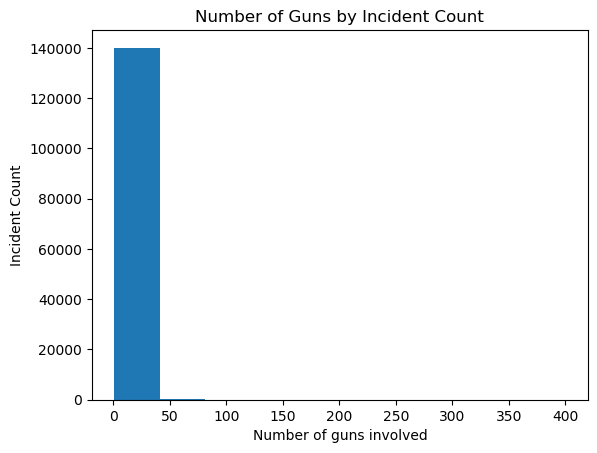

In [37]:
#The number of guns involved is heavily right skewed, with the highest number of >400, while most incidents involve <50 guns. 

plt.hist(df['n_guns_involved'])
plt.xlabel("Number of guns involved")
plt.ylabel("Incident Count")
plt.title("Number of Guns by Incident Count")

plt.show()

In [38]:
#Closer inspection shows that over half of all incidents involve 1 gun (53.2%) 
guns_inv=(df['n_guns_involved'].value_counts())/(len(df.index))
guns_inv

1.0      0.532166
2.0      0.031196
3.0      0.008432
4.0      0.003634
5.0      0.001815
           ...   
158.0    0.000004
189.0    0.000004
85.0     0.000004
96.0     0.000004
127.0    0.000004
Name: n_guns_involved, Length: 106, dtype: float64

In [39]:
df['n_guns_involved'].describe()

count    140226.000000
mean          1.372442
std           4.678202
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         400.000000
Name: n_guns_involved, dtype: float64

The mean and mode for the number of guns involved is both 1. Thus, we will impute 1 for all null values in 'n_guns_involved'

In [41]:
df['n_guns_involved'].fillna(value=1, inplace=True)

## Latitude and Longitude

### We will use city, state information to impute for latitude and longitude null values

In [ ]:
!pip install geopy

# Import the Nominatim class from geopy.geocoders
from geopy.geocoders import Nominatim

# Create an instance of the Nominatim class
geolocator = Nominatim(user_agent="my_app", timeout=10)
# Add the latitude/longitude information to the existing dataframe
df['Latitude'] = None
df['Longitude'] = None

# Loop through each row in the dataframe
for index, row in df.iterrows():
    # Check if the latitude and longitude values are null
    if pd.isnull(row['Latitude']) or pd.isnull(row['Longitude']):
        # Get the city and state values for the row
        city = row['city_or_county']
        state = row['state']
        
        # Use the geocoding API to obtain the latitude and longitude values
        location = geolocator.geocode(f"{city}, {state}")
        
        # If a location is found, assign the latitude and longitude values to the corresponding row in the dataframe
        if location is not None:
            df.at[index, 'Latitude'] = location.latitude
            df.at[index, 'Longitude'] = location.longitude

In [ ]:
# Define the chunksize for processing the dataset
chunksize = 50000

# Load the data into a Pandas DataFrame in chunks
df_chunks = pd.read_csv("{}/gun_violence.csv".format(s3_path), chunksize=chunksize)

# Group the DataFrame by city and state
grouped = pd.concat([chunk.groupby(['city_or_county', 'state']).apply(lambda x: x) for chunk in df_chunks])

# Create a copy of the DataFrame with no null values for latitude and longitude
non_null_df = grouped.dropna(subset=['latitude', 'longitude'], how='any')

# Merge the non-null DataFrame with the original DataFrame to impute the null values
merged_df = pd.merge(grouped, non_null_df, on=['city_or_county', 'state'], suffixes=('', '_non_null'))

# Use the non-null values to impute the null values
merged_df['latitude'].fillna(merged_df['latitude_non_null'], inplace=True)
merged_df['longitude'].fillna(merged_df['longitude_non_null'], inplace=True)

# Update the original DataFrame with the imputed values
grouped.update(merged_df[['latitude', 'longitude']])

# Reset the index of the updated DataFrame
grouped.reset_index(drop=True, inplace=True)

In [158]:
df.update(grouped)

In [159]:
df['longitude'].isnull().sum()

7923

# Analysis by Location

In [115]:
#2010 census information--state populations
statement = "SELECT stname, max(census2010pop) as pop_count from ads508.est2018 GROUP BY stname ORDER BY stname asc LIMIT 100"
state_pop=pd.read_sql(statement, conn)
state_pop=state_pop.tail(51)
state_pop

,stname,pop_count
2,Alabama,4779736.0
3,Alaska,710231.0
4,Arizona,6392017.0
5,Arkansas,2915918.0
6,California,37253956.0
7,Colorado,5029196.0
8,Connecticut,3574097.0
9,Delaware,897934.0
10,District of Columbia,601723.0
11,Florida,18801310.0


In [116]:
#show top 15 states w/ highest incident count
statement="SELECT state, count(*) as incident_count from ads508.gun_violence GROUP BY state ORDER BY count(*) DESC"
gb_state=pd.read_sql(statement, conn)
gb_state.iloc[2:16]

,state,incident_count
2,Illinois,17556
3,California,16306
4,Florida,15029
5,Texas,13577
6,Ohio,10244
7,New York,9712
8,Pennsylvania,8929
9,Georgia,8925
10,North Carolina,8739
11,Louisiana,8103


In [117]:
#show incident rate per state
statement="SELECT state, count(*) as incident_count FROM ads508.gun_violence GROUP BY state ORDER BY state DESC LIMIT 100"
gb_state=pd.read_sql(statement, conn)
gb_state=gb_state.head(51).iloc[::-1] #reverse order so that states are in alphabetical top to bottom
gb_state['state_pop']=state_pop['pop_count']
gb_state['incident_rate']=gb_state['incident_count']/gb_state['state_pop']
gb_state['incident_rate_per_100k']=gb_state['incident_rate']*100000

gb_state

,state,incident_count,state_pop,incident_rate,incident_rate_per_100k
50,Alabama,5471,1852994.0,0.002953,295.251900
49,Alaska,1349,6724540.0,0.000201,20.060852
48,Arizona,2328,8001024.0,0.000291,29.096276
47,Arkansas,2842,625741.0,0.004542,454.181522
46,California,16306,2763885.0,0.005900,589.966659
45,Colorado,3201,25145561.0,0.000127,12.729881
44,Connecticut,3067,6346105.0,0.000483,48.328857
43,Delaware,1685,814180.0,0.002070,206.956693
42,District of Columbia,3195,4625364.0,0.000691,69.075645
41,Florida,15029,1052567.0,0.014278,1427.842598


In [118]:
#show top 15 cities w/ highest incident count
statement="SELECT state,city_or_county,count(*) as incident_count from ads508.gun_violence GROUP BY state, city_or_county ORDER BY count(*) DESC"
gb_city=pd.read_sql(statement, conn)
gb_city.head(16)

,state,city_or_county,incident_count
0,None,None,22050
1,Illinois,Chicago,10814
2,Maryland,Baltimore,3943
3,District of Columbia,Washington,3189
4,Louisiana,New Orleans,3070
5,Pennsylvania,Philadelphia,2929
6,Missouri,Saint Louis,2498
7,Wisconsin,Milwaukee,2487
8,Texas,Houston,2480
9,Tennessee,Memphis,2384


In [119]:
#show top 15 congressional districts w/ highest incident count
statement="SELECT state,city_or_county,congressional_district, count(*) as incident_count from ads508.gun_violence GROUP BY state, city_or_county, congressional_district ORDER BY count(*) DESC"
gb_cong=pd.read_sql(statement, conn)
gb_cong.head(16)

,state,city_or_county,congressional_district,incident_count
0,None,None,NaN,22050
1,Illinois,Chicago,7.0,4219
2,Maryland,Baltimore,7.0,2792
3,Louisiana,New Orleans,2.0,2764
4,Illinois,Chicago,1.0,2494
5,Wisconsin,Milwaukee,4.0,2388
6,Missouri,Saint Louis,1.0,2368
7,District of Columbia,Washington,1.0,2324
8,Tennessee,Memphis,9.0,2248
9,Indiana,Indianapolis,7.0,1672


## Use GeoPandas to map all gun violence incidents

In [120]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [121]:
# wrap df w/ a GeoDataFrame by creating a geometry attribute
df_geo = GeoDataFrame(df, geometry=points_from_xy(df.longitude, df.latitude))
df_geo.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,target_class,geometry
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,1,POINT (-79.85590 40.34670)
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,1,POINT (-118.33300 33.90900)
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,1,POINT (-82.13770 41.44550)
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,1,POINT (-104.80200 39.65180)
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,1,POINT (-79.95690 36.11400)


/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


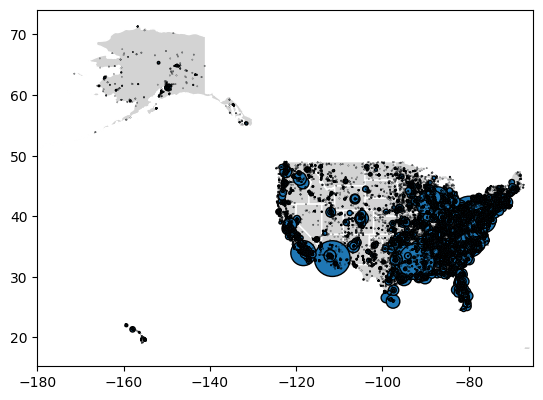

In [122]:
#mapped incident counts by city

from matplotlib.pyplot import figure

united_states = GeoDataFrame.from_file('state_shapefiles/')
#north_america.plot(color='lightgrey')

axes = united_states.plot(color='lightgrey', edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_city['incident_count']), edgecolors='black')
plt.xlim(xmin=-180,xmax=-65)
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


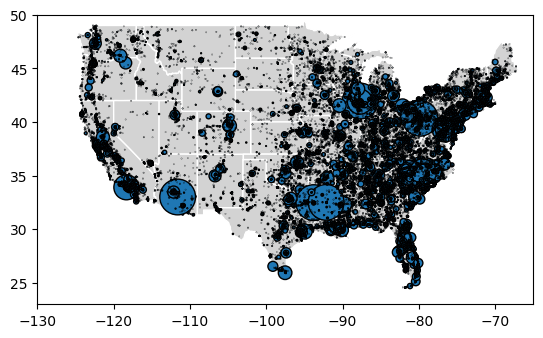

In [123]:
#mapped incident counts by city, zoomed into continental US

united_states = GeoDataFrame.from_file('state_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey',edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_city['incident_count']), edgecolors='black')
plt.xlim(xmin=-130,xmax=-65)
plt.ylim(ymin=23, ymax=50)
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


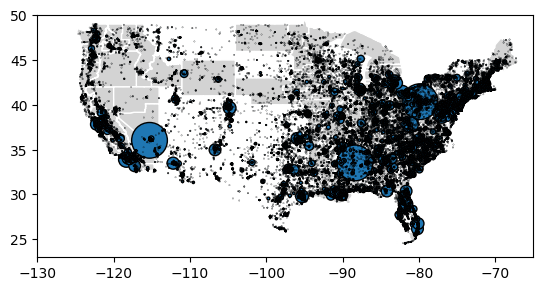

In [124]:
#mapped incident counts by congressional districts

united_states = GeoDataFrame.from_file('congressional_district_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey',edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_cong['incident_count']), edgecolors='black')
plt.xlim(xmin=-130,xmax=-65)
plt.ylim(ymin=23, ymax=50)
plt.show()

In [125]:
### Parse gun_type column and display histogram of gun type frequency

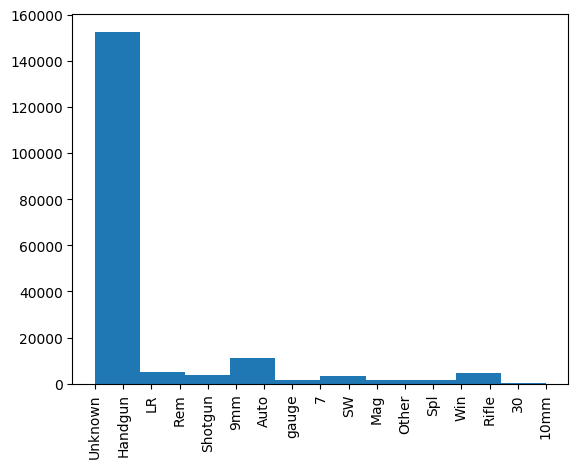

In [126]:
###############
# Gun Type
###############
import re
import math

guns_list = []

for item in df['gun_type']:

    if type(item) == float and math.isnan(item):
        continue

    gun = re.findall("\d*::\d* (?P<gun>\w*)", item)

    if len(gun) == 0:
        gun = re.findall("\d*::(?P<gun>\w*)", item)

    guns_list.extend(gun)

# print(guns_list)

plt.xticks(rotation="vertical")
plt.hist(guns_list)
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


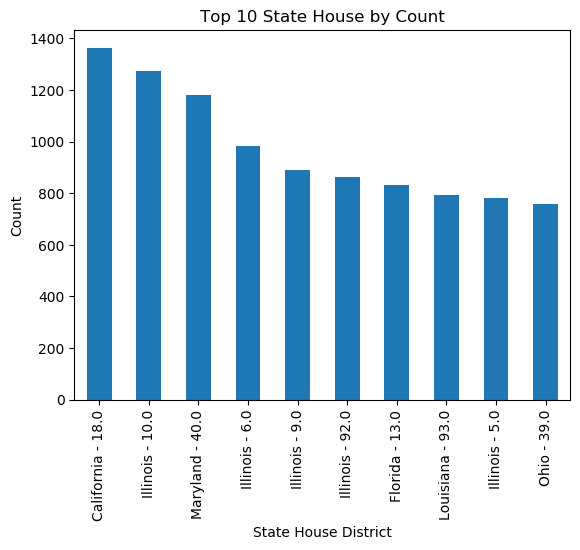

In [127]:
df_no_nans = df_geo.dropna(subset=['state_house_district'])

# Concatenate the state and state_house_district columns
df_no_nans['state_house_district'] = df_no_nans['state'] + ' - ' + df_no_nans['state_house_district'].astype(str)

# Get the top 10 state_districts by count
top10_districts = df_no_nans['state_house_district'].value_counts().nlargest(10)

# Plot the top 10 state_districts using a bar chart
top10_districts.plot(kind='bar')

# Add labels to the plot
plt.title('Top 10 State House by Count')
plt.xlabel('State House District')
plt.ylabel('Count')

# Show the plot
plt.show()

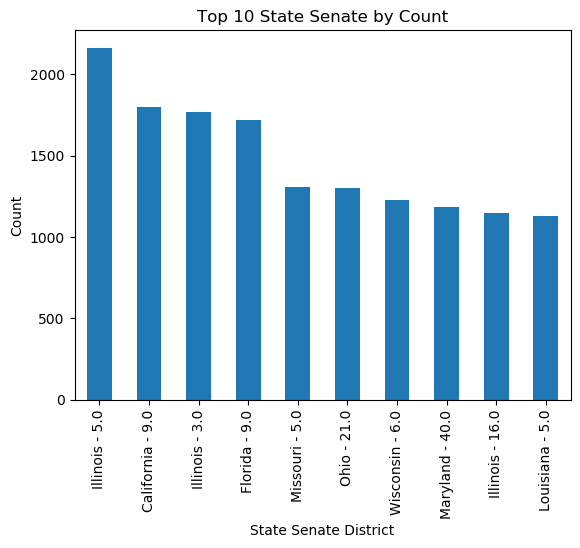

In [128]:
df_no_nans = df_geo.dropna(subset=['state_senate_district'])

# Concatenate the state and state_house_district columns
df_no_nans['state_senate_district'] = df_no_nans['state'] + ' - ' + df_no_nans['state_senate_district'].astype(str)

# Get the top 10 state_districts by count
top10_districts = df_no_nans['state_senate_district'].value_counts().nlargest(10)

# Plot the top 10 state_districts using a bar chart
top10_districts.plot(kind='bar')

# Add labels to the plot
plt.title('Top 10 State Senate by Count')
plt.xlabel('State Senate District')
plt.ylabel('Count')

# Show the plot
plt.show()

In [129]:
### Find the 10 most common words listed in the 'incident characteristics' column ###
### The regular expressions is used as a space delimiter, since some of the words ###
### are separated with spaces and others are separated with the "||" symbol ###

import re
from collections import Counter
import pandas as pd

df["incident_characteristics"] = df["incident_characteristics"].astype(str)

# create an empty Counter object
word_counts = Counter()

# loop through each row in the DataFrame
for index, row in df.iterrows():
    # split the "Incident_Characteristics" column into a list of words using a regular expression
    words = re.findall(r'\w+', row['incident_characteristics'])
    # update the Counter object with the words in this row
    word_counts.update(words)

# get the 10 most common words
most_common_words_10 = word_counts.most_common(10)

# print the results
print("The 10 most common words are:")
for word, count in most_common_words_10:
    print(f"{word}: {count}")

The 10 most common words are:
Shot: 147335
Wounded: 93926
Injured: 93926
Shooting: 79817
Incident: 76265
of: 73576
found: 71645
gun: 64222
suicide: 58307
or: 54245


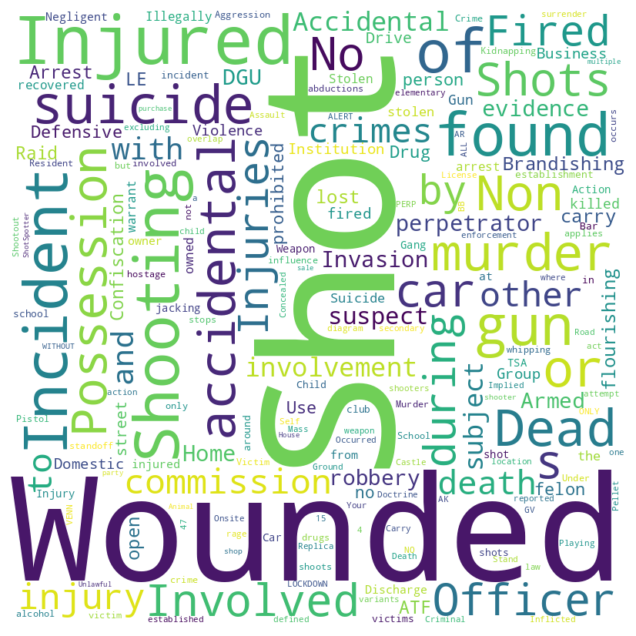

In [130]:
### Creating a word cloud of the most common words. Currently the count is 200, which ###
### feels like enough to get a good sense of the types of descriptive words used in ###
### the reports. ###

most_common_words_200 = word_counts.most_common(200)
most_common_words_dict = dict(most_common_words_200)

wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(most_common_words_dict)

# plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [131]:
# import requests
# from bs4 import BeautifulSoup

# # send a GET request to the webpage and get the HTML content
# url = "https://ballotpedia.org/Colorado_State_Senate"
# response = requests.get(url)
# html_content = response.content

# # create a BeautifulSoup object to parse the HTML content
# soup = BeautifulSoup(html_content, 'html.parser')

# # find the table element that contains the data
# table = soup.find('table', class_='infobox')

# # loop through each row in the table and extract the data
# for row in table.find_all('tr'):
#     # get the columns in this row
#     cols = row.find_all('td')
#     # if there are exactly 4 columns, extract the data and print it
#     if len(cols) == 4:
#         office = cols[0].get_text(strip=True)
#         name = cols[1].get_text(strip=True)
#         party = cols[2].get_text(strip=True)
#         date_assumed_office = cols[3].get_text(strip=True)
#         print(f"{office}: {name}, {party}, {date_assumed_office}")

In [132]:
# break up Participant Gender
# import matplotlib.pyplot as plt

# participant_gender = df['participant_gender']
# cleaned_row = []

# for row in participant_gender:
#     regex = 'Male'
#     match_males = re.findall(regex, str(row))

#     regex = 'Female'
#     match_females = re.findall(regex, str(row))

#     if match_males != None:
#         cleaned_row = cleaned_row + match_males
#     if match_females != None:
#         cleaned_row = cleaned_row + match_females

# plt.hist(cleaned_row)
# plt.show()

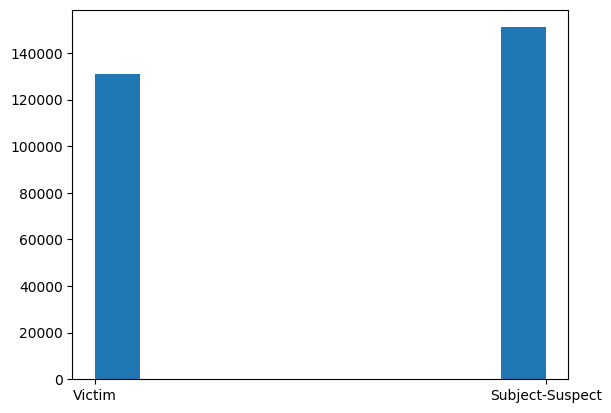

In [133]:
participant_type = df['participant_type']
cleaned = []

for parts in participant_type:

    if '||' in str(parts):
        part = str(parts).split('||')
        
        for keyval in part:
            if '::' in str(keyval):
                
                part_value = str(keyval).split('::')
                cleaned.append(part_value[1])

plt.hist(cleaned)
plt.show()

0.0     143654
1.0      60614
2.0      23119
3.0       8032
4.0       2907
5.0        861
6.0        229
7.0         89
8.0         58
10.0        24
9.0         23
15.0        10
11.0        10
13.0         7
12.0         7
14.0         5
20.0         3
16.0         3
19.0         3
21.0         3
24.0         3
29.0         2
52.0         1
17.0         1
28.0         1
27.0         1
18.0         1
23.0         1
35.0         1
63.0         1
22.0         1
30.0         1
32.0         1
Name: suspect_count, dtype: int64


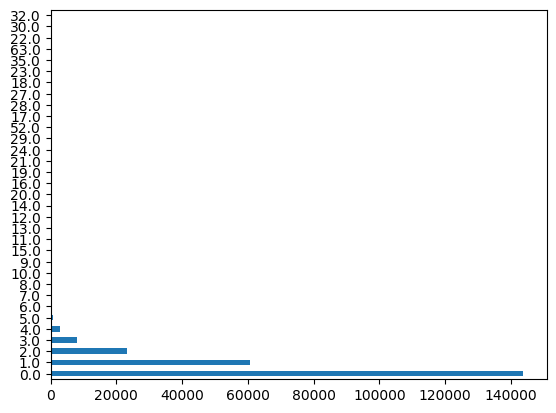

In [134]:
participant_type = df['participant_type']

i = 0

for parts in participant_type:

    suspects = []
    victims = []

    if '||' in str(parts):
        part = str(parts).split('||')
        for keyval in part:
            if '::' in str(keyval):
                part_value = str(keyval).split('::')
                if part_value[1] == 'Victim':
                    victims.append(part_value[1])
                elif part_value[1] == 'Subject-Suspect':
                    suspects.append(part_value[1])

    df.at[i,'victim_count'] = len(victims)
    df.at[i,'suspect_count'] = len(suspects)
    i = i + 1

plt.clf()
#plt.hist(df['suspect_count'], range=[0,7])
print(df['suspect_count'].value_counts())
df['suspect_count'].value_counts().plot(kind='barh')
plt.show()

In [135]:
from collections import Counter

phrases_list = []
count = 0

for i, row in df.iterrows():
    if (row['n_injured'] == 0 and row['n_killed'] == 0):
        count = count + 1
        #print(row['incident_characteristics'])
 
        if not isinstance(row['incident_characteristics'], float):

            incident_text = row['incident_characteristics']
            
            if '||' in str(incident_text):
                item = str(incident_text).split('||')
                
                for phrases in item:
                    phrases_list.append(phrases)


print("Number of incidents where injured = 0 and killed = 0: %d" % count)
print("Total rows in dataframe: %d" % len(df))
print("Percentage of none injured and none killed: %f" % (count/len(df)))


most_common_words_20 = Counter(phrases_list).most_common(25)
print("\n\n25 Most Common Phrases in Incident Characteristics column:")
for word, count in most_common_words_20:
    print(f"{word}: {count}")

Number of incidents where injured = 0 and killed = 0: 97287
Total rows in dataframe: 239677
Percentage of none injured and none killed: 0.405909


25 Most Common Phrases in Incident Characteristics column:
Non-Shooting Incident: 42753
Possession (gun(s) found during commission of other crimes): 23658
Shots Fired - No Injuries: 18949
ATF/LE Confiscation/Raid/Arrest: 16397
Brandishing/flourishing/open carry/lost/found: 13771
Drug involvement: 12785
Possession of gun by felon or prohibited person: 12450
Officer Involved Incident: 7630
Institution/Group/Business: 7251
Stolen/Illegally owned gun{s} recovered during arrest/warrant: 6575
Armed robbery with injury/death and/or evidence of DGU found: 5787
Home Invasion: 5152
Gun(s) stolen from owner: 5107
Home Invasion - No death or injury: 4950
Drive-by (car to street, car to car): 4192
Officer Involved Incident - Weapon involved but no shots fired: 3780
Car-jacking: 3370
Domestic Violence: 3168
Officer Involved Shooting - Shots fired, no inju

<Figure size 640x480 with 0 Axes>

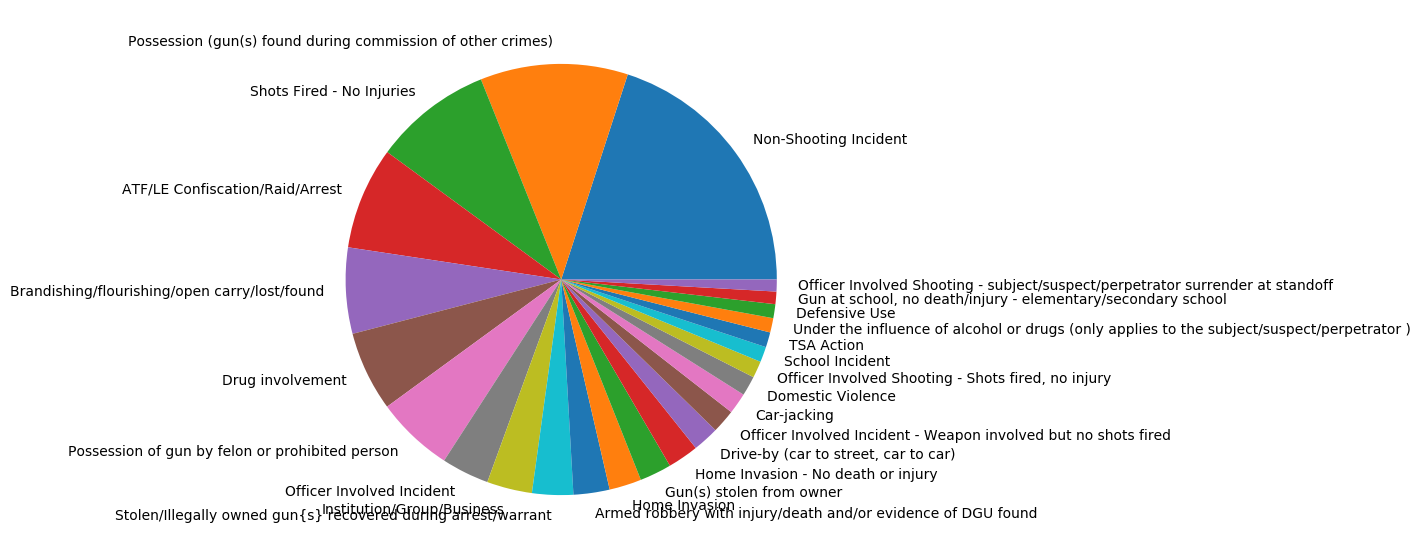

In [136]:
# Represent 20 Most Common Incident Characteristics as Pie Chart
# This is for the incidents where no one was injured or killed
words = []
counts = []

for word, count in most_common_words_20:
    words.append(word)
    counts.append(count)

temp = []
for c in counts:
    temp.append(c/len(counts))
    
plt.clf()
fig = plt.figure(figsize =(10, 7))
plt.pie(temp, labels = words)
 
# show plot
plt.show()

<Figure size 640x480 with 0 Axes>

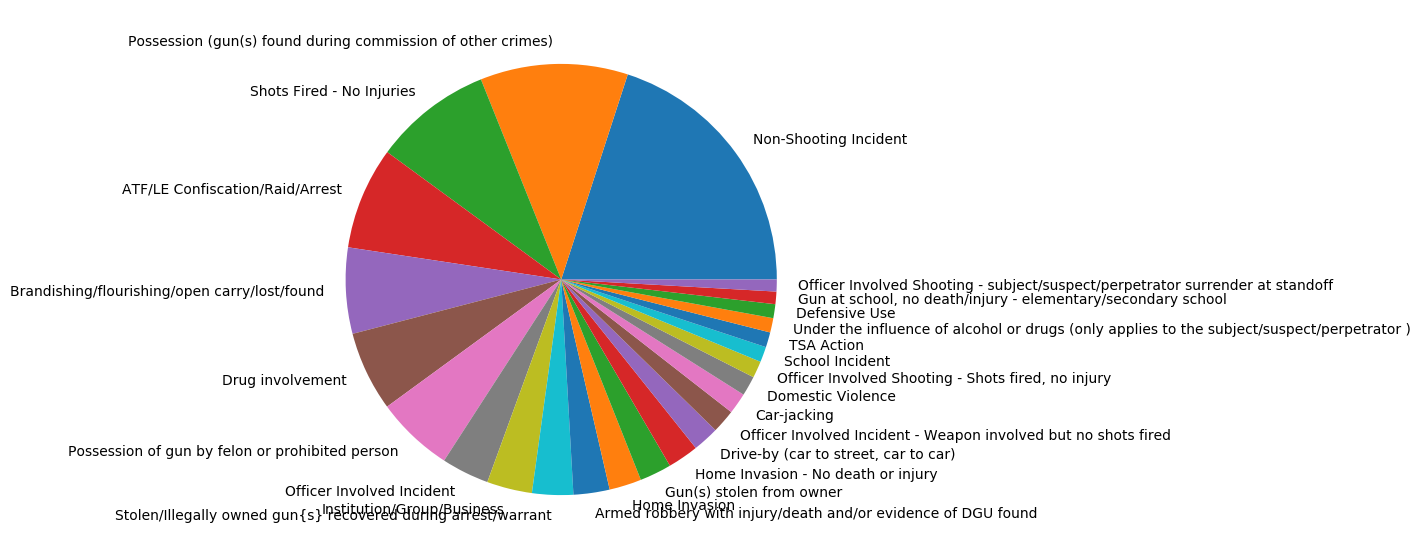

   incident_id        date           state city_or_county  \
0       461105  2013-01-01    Pennsylvania     Mckeesport   
1       460726  2013-01-01      California      Hawthorne   
2       478855  2013-01-01            Ohio         Lorain   
3       478925  2013-01-05        Colorado         Aurora   
4       478959  2013-01-07  North Carolina     Greensboro   

                                     address  n_killed  n_injured  \
0  1506 Versailles Avenue and Coursin Street         0          4   
1               13500 block of Cerise Avenue         1          3   
2                      1776 East 28th Street         1          3   
3           16000 block of East Ithaca Place         4          0   
4                  307 Mourning Dove Terrace         2          2   

                                        incident_url  \
0  http://www.gunviolencearchive.org/incident/461105   
1  http://www.gunviolencearchive.org/incident/460726   
2  http://www.gunviolencearchive.org/incident/4788

In [137]:
# Data Preprocessing - Get ZIP CODE
# assigns to new 'zipcode' column in dataframe
# Represent as Pie Chart
words = []
counts = []

for word, count in most_common_words_20:
    words.append(word)
    counts.append(count)

temp = []
for c in counts:
    temp.append(c/len(counts))
    
plt.clf()
fig = plt.figure(figsize =(10, 7))
plt.pie(temp, labels = words)
 
# show plot
plt.show()
!pip install geopy
import geopy
import pandas as pd

#longlat = pd.read_csv("longlat.csv",encoding = 'utf-8', sep = '\t')
geolocator = geopy.Nominatim(user_agent="check_1")

def get_zip_code(x):
    location = geolocator.reverse("{}, {}".format(x['latitude'],x['longitude']))
    return location.raw['address']['postcode']

df['zipcode'] = df.head().apply(lambda x: get_zip_code(x), axis = 1)
print(df.head(5))

# Analysis by Date

In [138]:
statement="SELECT year(date) as year, count(*) as incident_count, sum(n_killed) as total_killed, sum(n_injured) as total_injured from ads508.gun_violence GROUP BY year(date) ORDER BY year(date)"
year_count=pd.read_sql(statement, conn)
year_count

,year,incident_count,total_killed,total_injured
0,2013.0,278,317,979
1,2014.0,51854,12522,22960
2,2015.0,53579,13478,26937
3,2016.0,58763,15054,30551
4,2017.0,61401,15504,30691
5,2018.0,13802,3532,6171
6,NaN,110484,5256731,40728


In [139]:
statement="SELECT year(date) as year, month(date) as month, count(*) as incident_count, sum(n_killed) as total_killed, sum(n_injured) as total_injured from ads508.gun_violence GROUP BY year(date), month(date) ORDER BY year(date), month(date)"
month_count=pd.read_sql(statement, conn)
month_count

,year,month,incident_count,total_killed,total_injured
0,2013.0,1.0,15,23,44
1,2013.0,2.0,12,14,45
2,2013.0,3.0,19,25,75
3,2013.0,4.0,17,26,52
4,2013.0,5.0,27,20,101
...,...,...,...,...,...
59,2017.0,12.0,4622,1288,2169
60,2018.0,1.0,4926,1324,2365
61,2018.0,2.0,4124,1090,1714
62,2018.0,3.0,4752,1118,2092


# Analysis by Death/Injury Count

## Show the five deadliest shootings
### NOTE: Dataset does not include the Las Vegas shooting that occured October 1, 2017, which took the lives of 60 people.

In [140]:
statement="SELECT * FROM ads508.gun_violence ORDER BY n_killed desc LIMIT 10"
top_killed=pd.read_sql(statement, conn)
top_killed.head(5)


,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,172,None,000,52006,00000,52004,0,F,Nashville-Davidson metropolitan government (ba...,Tennessee,...,665396,669053,None,None,None,None,None,None,None,None
1,172,None,000,05140,00000,52004,0,A,Berry Hill city,Tennessee,...,525,517,None,None,None,None,None,None,None,None
2,172,None,000,63140,00000,52004,0,A,Ridgetop city,Tennessee,...,52,54,None,None,None,None,None,None,None,None
3,172,None,000,29920,00000,52004,0,A,Goodlettsville city,Tennessee,...,10642,10663,None,None,None,None,None,None,None,None
4,172,None,000,54780,00000,52004,0,A,Oak Hill city,Tennessee,...,4574,4553,None,None,None,None,None,None,None,None


## Combine the number of individuals killed and injured to get number of total involved


In [141]:
df['n_total']=df['n_killed'] + df['n_injured']
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_type,sources,state_house_district,state_senate_district,target_class,geometry,victim_count,suspect_count,zipcode,n_total
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,1,POINT (-79.85590 40.34670),4.0,1.0,15132,4
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,1,POINT (-118.33300 33.90900),4.0,1.0,90250,4
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,1,POINT (-82.13770 41.44550),3.0,2.0,44055,4
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,1,POINT (-104.80200 39.65180),3.0,1.0,80013,4
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,1,POINT (-79.95690 36.11400),3.0,1.0,27409,4


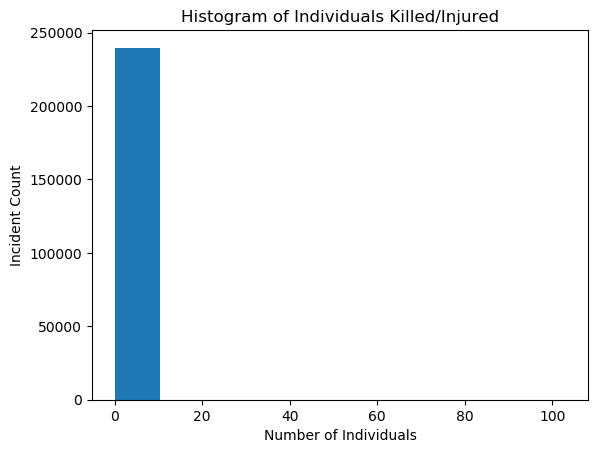

In [142]:
import matplotlib.ticker as mticker
plt.hist(df['n_total'])
plt.xlabel('Number of Individuals')
plt.ylabel('Incident Count')
plt.title('Histogram of Individuals Killed/Injured')
plt.show()

## Count of incidents with no injuries/deaths

In [143]:
statement="SELECT count(*) as count FROM ads508.gun_violence WHERE n_injured=0 and n_killed=0"
no_injury=pd.read_sql(statement, conn)
no_injury

,count
0,137486


In [144]:
## New Suspect Age Group Column

# Most suspects are adults 18+ category which doesn't tell us much, so the next column to create
# is the actual age of the suspect (see next block in this notebook)

              118175
Adult 18+     112493
Teen 12-17      8494
Child 0-11       515
Name: suspect_age, dtype: int64


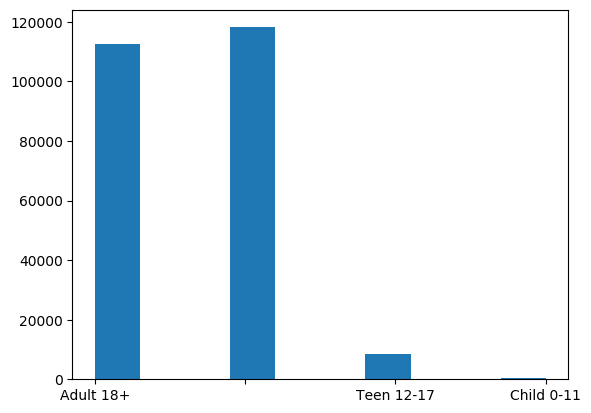

In [145]:
import pandas as pd
import re
import math
import matplotlib.pyplot as plt

df['suspect_age'] = ''

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_age_group']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            #print("empty element: --%s--" % element[0])
                            pass
                        df.at[i, 'suspect_age'] = element[0]
                    else:
                        df.at[i, 'suspect_age'] = match_age[0]
                        #print("i = %d" % i)
                else:
                    continue


print(df['suspect_age'].value_counts())
plt.clf()
plt.hist(df['suspect_age'])
plt.show()

In [146]:
## New Suspect Age Column

dataframe size: 239677


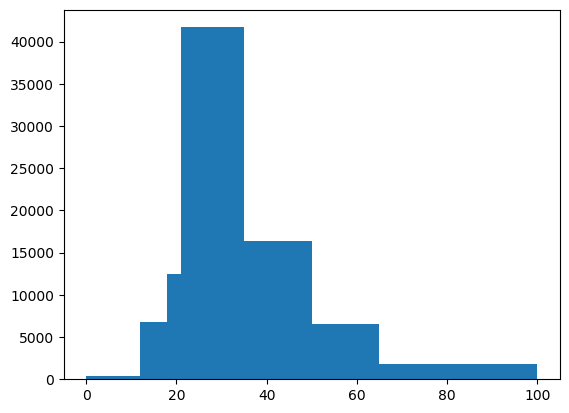

In [147]:
# actual age of suspect
df['suspect_age_value'] = ''
df[['suspect_age_value']] = df[['suspect_age_value']].apply(pd.to_numeric)

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_age']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            pass
                            #print("empty element: --%s--" % element[0])
                        else:
                            df.at[i, 'suspect_age_value'] = int(element[0])
                    else:
                        if match_age[0] == '':
                            #print("do nothing")
                            pass
                        else:
                            df.at[i, 'suspect_age_value'] = int(match_age[0])
                        #print("i = %d" % i)
                else:
                    continue


#print(df['suspect_age_value'].value_counts())
plt.clf()
#df = df.dropna(subset=['suspect_age_value'])
#print(type(df_temp.iloc[0]['suspect_age_value']))
#df_temp['suspect_age_value'] = df_temp['suspect_age_value'].apply(int)
print("dataframe size: %d" % len(df))
plt.hist(df['suspect_age_value'], bins=[0,12,18,21,35,50,65,100])
plt.show()

In [148]:
# Create Suspect Gender Column

# 'Gender Unknown' can mean two things:
# 1: There was a suspect but the gender was not recorded in the dataset
# 2: There was no suspect in the incident

size of dataframe at start: 239677


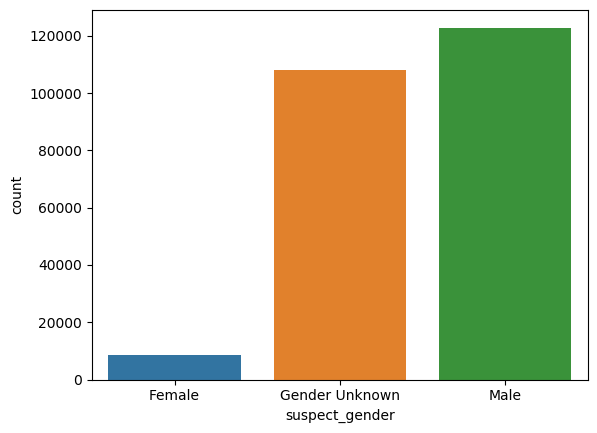

In [149]:
def has_numbers(inputString):
    if inputString != 'Male' and inputString != 'Female':
        #print("stop here")
        pass

    #print(type(inputString))
    for char in inputString:
        result = char.isdigit()
        if(result == True):
            return result
    #return any(char.isdigit() for char in inputString)
    
print("size of dataframe at start: %d" % len(df))

df['suspect_gender'] = ''
df[['suspect_gender']] = df[['suspect_gender']].apply(str)
# 0 = male
# 1 = female

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_gender row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_gender']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            #print("empty element: --%s--" % element[0])
                            pass
                        else:
                            if has_numbers(element[0]):
                                df.at[i, 'suspect_gender'] = 'Gender Unknown'
                            else:
                                df.at[i, 'suspect_gender'] = element[0]
                    else:
                        if match_age[0] == '':
                            #print("do nothing")
                            pass
                        else:
                            if has_numbers(match_age[0]):
                                df.at[i, 'suspect_gender'] = 'Gender Unknown'
                            else:
                                df.at[i, 'suspect_gender'] = match_age[0]
                        #print("i = %d" % i)
                else:
                    continue


#print(df['suspect_gender'].value_counts())
plt.clf()
#print("number of rows before dropna(): %d" % len(df))
df_temp = df.dropna(subset=['suspect_gender'])
#print("number of rows after dropna(): %d" % len(df_temp))
#df_temp['suspect_gender'] = df['suspect_gender'].replace('0', 'Unknown')

for i,row in df_temp.iterrows():
    result = row['suspect_gender']
    if result != 'Female' and result != 'Male':
        df_temp.at[i, 'suspect_gender'] = 'Gender Unknown'
    #print(result)

import seaborn as sns

df = df_temp.copy()

sns.countplot(x = df['suspect_gender'], data = df)
plt.show()

In [150]:
print(df.columns)

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district', 'target_class', 'geometry', 'victim_count',
       'suspect_count', 'zipcode', 'n_total', 'suspect_age',
       'suspect_age_value', 'suspect_gender'],
      dtype='object')
